## Exploratory Data Analysis (Keystroke Dataset)

In [1]:
import pickle
import types
from math import ceil
from functools import partial

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interact_manual, widgets
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from scipy import stats
from statsmodels.stats.multitest import multipletests
from tqdm.auto import tqdm

In [2]:
plt.style.use('./plt_style.txt')

In [3]:
with open('large_dataset.pickle', 'rb') as f:
    d = pickle.load(f)
    keystrokes, grades = d['logs'], d['grades']

In [4]:
%matplotlib widget

---

# Analysis

In [5]:
keystrokes.event_type.unique()

array(['text_insert', 'text_remove', 'submit', 'focus_gained',
       'focus_lost', 'run'], dtype=object)

## Keystroke Summary

In [6]:
grades = grades.set_index(['semester', 'class', 'student'])
grades = grades[~grades.grade.isna()]

In [7]:
#keystrokes = keystrokes.sort_values('time_to_deadline', ascending=False)
keystrokes = keystrokes.set_index(['semester', 'class', 'student'])
keystrokes.time_to_deadline = keystrokes.time_to_deadline.dt.total_seconds()

In [8]:
len(keystrokes.index)

3086272

In [9]:
keystrokes.groupby(keystrokes.index).count().time_to_deadline.mean()

1032.543325526932

In [10]:
f"Number of student/class: {len(keystrokes.index.unique())}"

'Number of student/class: 2989'

In [11]:
f"Number of events: {len(keystrokes.index)}"

'Number of events: 3086272'

In [12]:
keystrokes.event_type.value_counts()

text_insert     1753827
text_remove      682098
focus_lost       233215
focus_gained     199576
run              111362
submit           106194
Name: event_type, dtype: int64

## Grade Distributions

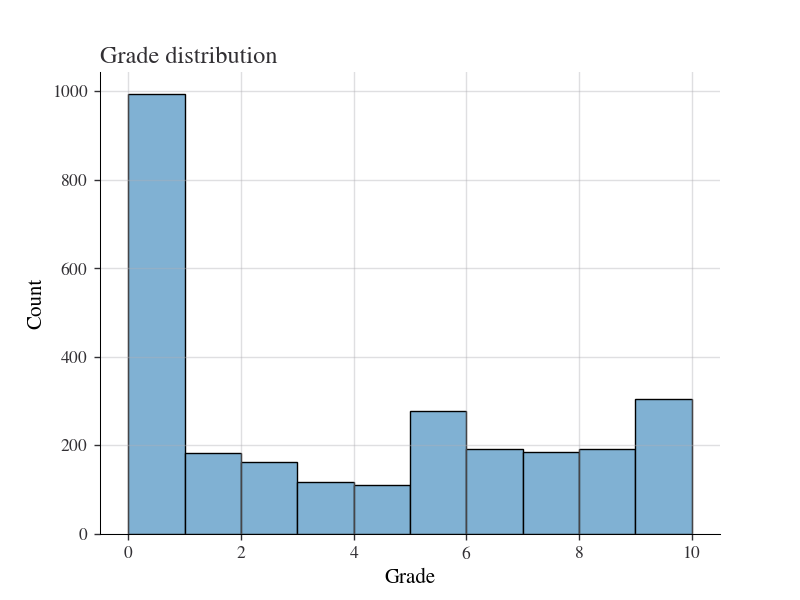

In [13]:
plt.figure()
plt.hist(grades.grade)
plt.grid(alpha=0.4)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.title(f'Grade distribution')
plt.show()

## Summary Features

In [14]:
groups = keystrokes.groupby(['semester', 'class', 'student', keystrokes.assignment_excercise])

In [15]:
time_to_first_event = groups.time_to_deadline.max().unstack(level=-1)

In [16]:
time_to_last_event = groups.time_to_deadline.min().unstack(level=-1)

In [17]:
ks_submits = keystrokes.where(keystrokes.event_type == 'submit')
first_submit = ks_submits.groupby(['semester', 'class', 'student', ks_submits.assignment_excercise]).time_to_deadline.max().unstack(level=-1)

In [18]:
differences = -groups.apply(lambda g: g.sort_values('time_to_deadline', ascending=False).time_to_deadline.diff())

In [19]:
assert (~(differences[~differences.isna()] < 0)).all()

---

In [20]:
all_latencies = differences.groupby('student')

In [21]:
max_latency = differences.quantile(0.995)

In [22]:
filtered_latencies = differences[differences < max_latency]

In [23]:
regrouped = filtered_latencies.groupby(['semester', 'class', 'student'])
mean_latency = regrouped.mean()
fine_time_on_task = regrouped.sum()

---

In [24]:
keystroke_counts = keystrokes.groupby(['semester', 'class', 'student']).event_type.apply(pd.value_counts).unstack(level=-1).fillna(0);

In [25]:
keystrokes.groupby(['semester', 'class', 'student']).event_type.apply(pd.value_counts).unstack(level=-1)

focus_gained  focus_lost    run  submit  text_insert  \
semester class student                                                         
2016-1   102   1278              NaN         NaN    NaN    28.0        448.0   
               1279              9.0         5.0    NaN     7.0        358.0   
               1280              NaN         NaN    NaN    16.0        682.0   
               1281              NaN         NaN    NaN    14.0        617.0   
               1283              NaN         NaN    NaN    13.0        534.0   
...                              ...         ...    ...     ...          ...   
2021-2   357   6038            229.0       342.0  245.0   158.0       3469.0   
               6108             99.0       154.0   87.0     1.0        753.0   
               6141             54.0        86.0   48.0    24.0        308.0   
               6193             69.0        96.0   38.0    14.0       1002.0   
               6216              1.0         NaN    NaN     NaN         30.0   

                        text_remove  
semester class student               
2016-1   102   1278            99.0  
               1279           106.0  
               1280           214.0  
               1281           109.0  
               1283           231.0  
...                             ...  
2021-2   357   6038          2559.0  
               6108           190.0  
               6141           210.0  
               6193           464.0  
               6216             1.0  

[2989 rows x 6 columns]

In [26]:
summary_features = keystroke_counts.assign(
    time_to_last = time_to_last_event.mean(axis=1),
    time_to_first=time_to_first_event.mean(axis=1),
    duration=(time_to_first_event-time_to_last_event).mean(axis=1),
    coarse_time_on_task=(time_to_first_event-first_submit).mean(axis=1),
    fine_time_on_task=fine_time_on_task,
    mean_latency=mean_latency
)
summary_features['coarse_time_on_task']=summary_features['coarse_time_on_task'].fillna(summary_features['coarse_time_on_task'].max()+100)
summary_features['mean_latency'] = summary_features['mean_latency'].fillna(0)
summary_features['fine_time_on_task'] = summary_features['fine_time_on_task'].fillna(0)
summary_features

focus_gained  focus_lost    run  submit  text_insert  \
semester class student                                                         
2016-1   102   1278              0.0         0.0    0.0    28.0        448.0   
               1279              9.0         5.0    0.0     7.0        358.0   
               1280              0.0         0.0    0.0    16.0        682.0   
               1281              0.0         0.0    0.0    14.0        617.0   
               1283              0.0         0.0    0.0    13.0        534.0   
...                              ...         ...    ...     ...          ...   
2021-2   357   6038            229.0       342.0  245.0   158.0       3469.0   
               6108             99.0       154.0   87.0     1.0        753.0   
               6141             54.0        86.0   48.0    24.0        308.0   
               6193             69.0        96.0   38.0    14.0       1002.0   
               6216              1.0         0.0    0.0     0.0         30.0   

                        text_remove  time_to_last  time_to_first  \
semester class student                                             
2016-1   102   1278            99.0  8.600522e+06   8.601953e+06   
               1279           106.0  6.988069e+06   7.390790e+06   
               1280           214.0  8.599192e+06   8.600450e+06   
               1281           109.0  8.597850e+06   8.598177e+06   
               1283           231.0  8.597969e+06   8.598170e+06   
...                             ...           ...            ...   
2021-2   357   6038          2559.0  4.375141e+06   4.777416e+06   
               6108           190.0  2.492641e+06   2.977883e+06   
               6141           210.0  3.937940e+06   3.942484e+06   
               6193           464.0  2.312932e+06   2.313388e+06   
               6216             1.0  2.246905e+06   2.246918e+06   

                             duration  coarse_time_on_task  fine_time_on_task  \
semester class student                                                          
2016-1   102   1278       1430.688571         1.495457e+02           7491.842   
               1279     402721.182500         4.027188e+05           1190.843   
               1280       1258.210429         3.489247e+02           3076.582   
               1281        327.293286         2.660076e+02           2291.053   
               1283        200.720857         1.844351e+02           1405.046   
...                               ...                  ...                ...   
2021-2   357   6038     402275.582000         1.205623e+05          42800.804   
               6108     485242.223300         5.167503e+04           9683.282   
               6141       4544.345857         5.444286e+02          11476.600   
               6193        455.577600         3.841212e+02           6833.664   
               6216         13.493000         3.645417e+06             13.493   

                        mean_latency  
semester class student                
2016-1   102   1278        13.213125  
               1279         2.491303  
               1280         3.407068  
               1281         3.125584  
               1283         1.822368  
...                              ...  
2021-2   357   6038         6.159275  
               6108         7.624631  
               6141        16.006416  
               6193         4.096921  
               6216         0.435258  

[2989 rows x 12 columns]

In [27]:
grades = grades[grades.index.isin(summary_features.index)]

## Correlations

In [28]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

/home/zac/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/zac/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


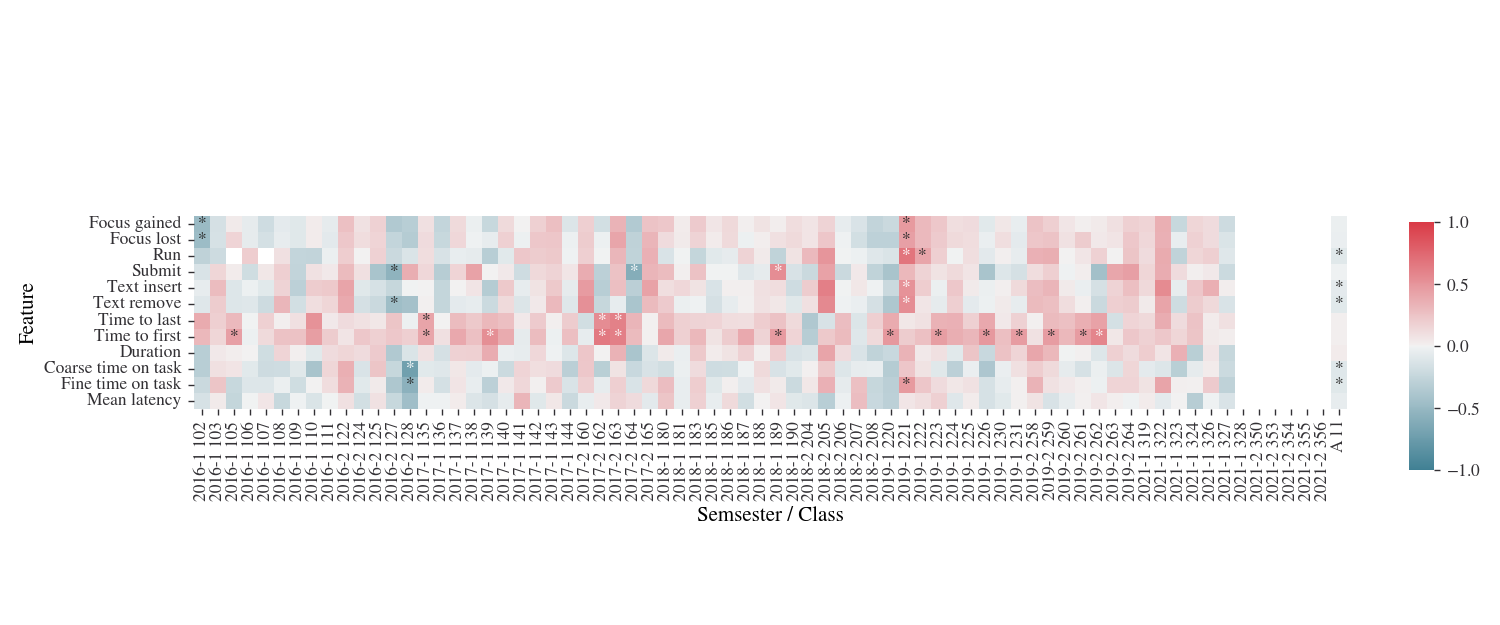

In [29]:
indexes = []
per_class_correlations = []
per_class_p = []
for (index, group), (_, grades_group) in zip(
    summary_features.groupby(['semester', 'class']), 
    grades.groupby(['semester', 'class'])
):
    try:
        data = group.assign(final=grades_group)
    except KeyError:
        pass
    corr = data.corr(method='spearman')['final']
    per_class_correlations.append(corr)
    per_class_p.append(data.corr(method=lambda x, y: stats.spearmanr(x,y)[1])['final'])
    indexes.append(index)

# Append vs all correlation & p value
per_class_correlations.append(summary_features.assign(final=grades).corr()['final'])
per_class_p.append(summary_features.assign(final=grades).corr(method=lambda x, y: stats.pearsonr(x,y)[1])['final'])
indexes.append('All')

per_class_correlations = pd.DataFrame(per_class_correlations, index=indexes).rename(lambda name: name.replace("_", " ").capitalize(), axis=1).T.iloc[:-1,]
per_class_p = pd.DataFrame(per_class_p, index=indexes).T.iloc[:-1,]

# Bonferroni correction
per_class_p_uncorrected = per_class_p
per_class_p = per_class_p.apply(lambda klass: multipletests(klass.to_numpy(), alpha=0.05, method='bonferroni')[1], axis=0)

annot = [[f"{'*' if r < 0.05 else ''}" for val, r in zip(row, q)] for row, q in zip(per_class_correlations.to_numpy(), per_class_p.to_numpy())]

plt.figure(figsize=(12,5))
ax = sns.heatmap(
    per_class_correlations,
    square=True, 
    cbar_kws={"orientation": "vertical", "fraction": 0.02, "aspect": 10, "anchor": (0., 0.4)},
    xticklabels=[" ".join(index) for index in indexes],
    vmin=-1.,
    vmax=1.,
    annot=annot,
    fmt='s',
    cmap=cmap
)
plt.xlabel("Semsester / Class")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig('figures/correlations_to_final_by_class.png', bbox_inches='tight')
plt.savefig('figures/correlations_to_final_by_class.pdf', bbox_inches='tight');

Fraction of classes with at least one significant correlation:

In [30]:
def fraction_significant_correlations(p, axis=0):
    has_significant = (p < 0.05).any(axis=axis)
    return np.count_nonzero(has_significant) / has_significant.shape[0]
fraction_significant_correlations(per_class_p)

0.2777777777777778

In [31]:
np.count_nonzero((per_class_p.loc['time_to_first'] < 0.05)[:-1])/71

0.18309859154929578

In [32]:
per_class_correlations

,"(2016-1, 102)","(2016-1, 103)","(2016-1, 105)","(2016-1, 106)","(2016-1, 107)","(2016-1, 108)","(2016-1, 109)","(2016-1, 110)","(2016-1, 111)","(2016-2, 122)",...,"(2021-1, 324)","(2021-1, 326)","(2021-1, 327)","(2021-1, 328)","(2021-2, 350)","(2021-2, 353)","(2021-2, 354)","(2021-2, 355)","(2021-2, 356)",All
Focus gained,-0.485234,-0.154722,0.045953,-0.060610,-0.188638,-0.065728,-0.093628,0.038596,-0.060134,0.269189,...,0.149693,0.122329,-0.200170,NaN,NaN,NaN,NaN,NaN,NaN,-0.028552
Focus lost,-0.472617,-0.144751,0.159862,-0.057980,-0.158247,-0.051541,-0.093628,0.034226,-0.077224,0.233145,...,0.179201,0.121757,-0.121324,NaN,NaN,NaN,NaN,NaN,NaN,-0.038404
Run,-0.274010,-0.199008,NaN,0.198022,NaN,0.098880,-0.257372,-0.258199,-0.024275,0.196343,...,0.155764,0.190057,-0.095925,NaN,NaN,NaN,NaN,NaN,NaN,-0.088786
Submit,-0.132353,0.153223,0.035422,-0.181843,0.058024,0.190055,-0.261858,0.091509,0.053854,0.303941,...,0.015953,0.049349,-0.204925,NaN,NaN,NaN,NaN,NaN,NaN,-0.015308
Text insert,-0.051068,0.291739,-0.103004,-0.022382,-0.081817,0.168546,-0.294805,0.207018,0.225100,0.423478,...,0.239525,0.365603,0.029395,NaN,NaN,NaN,NaN,NaN,NaN,-0.069193
Text remove,-0.096241,0.204950,-0.103494,-0.098153,-0.198660,0.322662,-0.166342,0.101754,0.150500,0.396522,...,0.203496,0.135509,-0.130090,NaN,NaN,NaN,NaN,NaN,NaN,-0.079360
Time to last,0.383565,0.188493,0.310596,-0.000720,0.184707,0.021294,0.100000,0.522807,0.048250,0.120000,...,0.253559,0.033737,0.098898,NaN,NaN,NaN,NaN,NaN,NaN,0.016139
Time to first,0.314406,0.155566,0.449920,-0.017338,0.131832,0.264220,0.261039,0.454386,0.204402,0.076522,...,0.245540,0.043271,0.029952,NaN,NaN,NaN,NaN,NaN,NaN,0.020181
Duration,-0.319918,0.048809,0.023868,0.003890,-0.182691,0.159148,0.016883,-0.080702,0.120512,0.152174,...,-0.309407,0.068574,-0.238553,NaN,NaN,NaN,NaN,NaN,NaN,0.034606
Coarse time on task,-0.317732,0.097637,0.071874,-0.080309,-0.198696,-0.194452,-0.093506,-0.400000,0.154264,0.363478,...,-0.055325,0.032270,-0.205201,NaN,NaN,NaN,NaN,NaN,NaN,-0.100268


In [33]:
per_class_p

,"(2016-1, 102)","(2016-1, 103)","(2016-1, 105)","(2016-1, 106)","(2016-1, 107)","(2016-1, 108)","(2016-1, 109)","(2016-1, 110)","(2016-1, 111)","(2016-2, 122)",...,"(2021-1, 324)","(2021-1, 326)","(2021-1, 327)","(2021-1, 328)","(2021-2, 350)","(2021-2, 353)","(2021-2, 354)","(2021-2, 355)","(2021-2, 356)",All
focus_gained,0.004916,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.0,1.000000,...,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
focus_lost,0.007270,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.0,1.000000,...,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.611820
run,0.681061,1.000000,NaN,1.0,NaN,1.00000,1.0,1.000000,1.0,1.000000,...,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000075
submit,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.0,1.000000,...,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
text_insert,1.000000,0.349637,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.0,0.470447,...,1.000000,0.475392,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.005196
text_remove,1.000000,1.000000,1.000000,1.0,1.0,0.70432,1.0,1.000000,1.0,0.660821,...,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000648
time_to_last,0.078206,1.000000,0.427841,1.0,1.0,1.00000,1.0,0.259643,1.0,1.000000,...,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
time_to_first,0.333552,1.000000,0.020472,1.0,1.0,1.00000,1.0,0.607820,1.0,1.000000,...,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
duration,0.300414,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.0,1.000000,...,0.624518,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.944027
coarse_time_on_task,0.313213,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.0,0.969944,...,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000004


In [34]:
per_class_correlations.T.max()

Focus gained           0.484362
Focus lost             0.452692
Run                    0.673479
Submit                 0.542157
Text insert            0.619863
Text remove            0.564197
Time to last           0.617053
Time to first          0.653885
Duration               0.429423
Coarse time on task    0.363478
Fine time on task      0.480433
Mean latency           0.329998
dtype: float64

In [35]:
per_class_correlations.T.min()

Focus gained          -0.485234
Focus lost            -0.472617
Run                   -0.314472
Submit                -0.594669
Text insert           -0.335655
Text remove           -0.458339
Time to last          -0.361895
Time to first         -0.325820
Duration              -0.393283
Coarse time on task   -0.713258
Fine time on task     -0.561665
Mean latency          -0.449625
dtype: float64

In [36]:
per_class_correlations.loc['Time to first'].abs().min()

0.009022556390977444

In [37]:
np.count_nonzero(per_class_correlations.iloc[:-1,:-5].max(axis=1) > 0.2) / 70

0.15714285714285714

Prior work has proposed designed state models based on various events sourced from programming activity.

As an alternative to these designed models we experiment with a HMM trained on each student. The parameters of this HMM (start state, transition probabilities, emission probabilities) are used as the input to a regressor (a support vector regressor or random forest regressor).

In [38]:
train_ids, test_ids = train_test_split(keystrokes.index.unique(), test_size=0.5, stratify=grades.exam3)

AttributeError: 'DataFrame' object has no attribute 'exam3'

In [ ]:
encoder = LabelEncoder()
encoder.fit(list(keystrokes.event_type.value_counts().index))

In [ ]:
X = []
for studentid, student_keystrokes in tqdm(keystrokes.groupby(keystrokes.index)):
    model = hmm.GaussianHMM(n_components=5)
    model.fit(
        encoder.transform(student_keystrokes.event_type.to_numpy()).reshape(-1, 1),
        student_keystrokes.groupby("exercise").apply(lambda x: x.shape[0]).to_numpy()
    )
    params = np.concatenate((model.startprob_, model.transmat_.reshape(-1), model.means_.reshape(-1), model.covars_.reshape(-1)))
    X.append(params)
X = np.array(X)

### SVM

In [ ]:
clf = SVR()
clf.fit(X[train_ids], grades.exam3[train_ids])
predicted = clf.predict(X[test_ids])
r2_score(grades.exam3[test_ids], predicted)

### Random Forest

In [ ]:
clf = RandomForestRegressor(n_jobs=-1)
clf.fit(X[train_ids], grades.exam3[train_ids])
predicted = clf.predict(X[test_ids])
r2_score(grades.exam3[test_ids], predicted)

In [ ]:
@interact(feat=widgets.Dropdown(options=list(range(X.shape[1])), value=np.argmax(clf.feature_importances_)))
def plot_residuals(feat):
    plt.scatter(X[test_ids, feat], predicted-grades.exam3[test_ids])
    plt.axhline(0, ls='--', color='grey')

In [ ]:
keystrokes_np = list(ks.to_numpy() for student, ks in keystrokes.groupby(keystrokes.index))
for i in tqdm(range(len(keystrokes_np)), total=len(keystrokes_np)):
    keystrokes_np[i][:,0] = encoder.transform(keystrokes_np[i][:,0].reshape(-1,1))
    keystrokes_np[i] = np.delete(keystrokes_np[i], 1, axis=1)
    keystrokes_np[i] = np.c_[keystrokes_np[i][:,1], keystrokes_np[i][:,0]]
    keystrokes_np[i] = np.pad(keystrokes_np[i], [(0, 55750-keystrokes_np[i].shape[0]), (0,0)])
#keystrokes_np

In [ ]:
np.array(keystrokes_np).shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(keystrokes_np), grades.final)
classifier = ComposableTimeSeriesForestRegressor(n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
from sktime.datasets import load_arrow_head

In [ ]:
load_arrow_head()[0].iloc[0]

In [ ]:
load_arrow_head()[1]

## Models

In [39]:
summary_features = summary_features[summary_features.index.isin(grades.index)]

In [40]:
len([x[1] for x in summary_features.groupby(summary_features.index.get_level_values(0))][:-1])

9

In [41]:
@interact(
    summary_features=widgets.fixed(summary_features),
    grades=widgets.fixed(grades),
    model=widgets.Dropdown(options=[partial(RandomForestRegressor, random_state=42), LinearRegression]),
    split=widgets.Dropdown(options=['train_test_sem_1', '5fold_sem_1', '5fold_sem_2', '2sem', 'rolling'], value='2sem'),
    target=widgets.Dropdown(options=grades.columns, value='grade'),
    plot_importance=False,
    plot_scatter=False,
    norm=False,
    random_state=42
)
def evaluate_regression(summary_features, grades, model, split, plot_importance, norm, plot_scatter, target, random_state, silent=False):
    features = pd.DataFrame(Normalizer().fit_transform(summary_features), index=summary_features.index) if norm else summary_features
    
    if split == '5fold_sem_1' or split == '5fold_sem_2':
        train_ids, test_ids = train_test_split(keystrokes.index.unique(), test_size=0.5, random_state=random_state)
        folds = KFold(random_state=42, shuffle=True)
        summary_train = []
        summary_test = []
        grades_train = []
        grades_test = []
        for train_ids, test_ids in folds.split(features):
            print(train_ids)
            summary_train_ = features.iloc[train_ids]
            summary_test_ = features.iloc[test_ids]
            grades_train_ = grades[target].iloc[train_ids]
            grades_test_ = grades[target].iloc[test_ids]
        
            summary_train.append(summary_train_)
            summary_test.append(summary_test_)
            grades_train.append(grades_train_)
            grades_test.append(grades_test_)
    elif split == '2sem':
        train_semesters = ['2016-1', '2016-2', '2017-1', '2017-2', '2018-1', '2018-2', '2019-1', '2019-2']
        test_semesters = ['2021-1', '2021-2']
        summary_train = [summary_features.loc[train_semesters]]
        summary_test = [summary_features.loc[test_semesters]]
        grades_train = [grades.grade.loc[train_semesters]]
        grades_test = [grades.grade.loc[test_semesters]]
    elif split == 'rolling':
        summary_train = [x[1] for x in summary_features.groupby(summary_features.index.get_level_values(0))][:-1]
        summary_test = [x[1] for x in summary_features.groupby(summary_features.index.get_level_values(0))][1:]
        grades_train = [x[1].grade for x in grades.groupby(grades.index.get_level_values(0))][:-1]
        grades_test = [x[1].grade for x in grades.groupby(grades.index.get_level_values(0))][1:]
                
    r2s = []
    adj_r2s = []
    for summary_train_, summary_test_, grades_train_, grades_test_ in zip(summary_train, summary_test, grades_train, grades_test):
        clf = model()
        clf.fit(summary_train_, grades_train_)
        predicted = clf.predict(summary_test_)
        r2 = r2_score(grades_test_, predicted)
        adj_r2 = 1-(1-r2)*(summary_test_.shape[0]-1)/(summary_test_.shape[0]-summary_test_.shape[1]-1)
        r2s.append(r2)
        adj_r2s.append(adj_r2)
        
        if not silent:
            print(f"adjusted r^2 {adj_r2}")
    
    if plot_importance:
        plt.figure()
        plt.bar(summary_train.columns, clf.feature_importances_)
        plt.xticks(rotation='vertical')
        plt.grid(alpha=0.4)
        plt.tight_layout()
        plt.show()
        
    if plot_scatter:
        plt.figure()
        plt.scatter(predicted, grades_test)
        plt.xlabel("Predicted")
        plt.ylabel("Final Grade")
        plt.grid(alpha=0.4)
        plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='grey', ls='--')
        plt.show()
    
    return np.mean(r2s), np.mean(adj_r2s)

interactive(children=(Dropdown(description='model', options=(functools.partial(<class 'sklearn.ensemble._fores…

## Bootstrap

In [42]:
@interact_manual(
    summary_features=widgets.fixed(summary_features),
    grades=widgets.fixed(grades),
    model=widgets.Dropdown(options=[partial(RandomForestRegressor, random_state=42), LinearRegression]),
    split=widgets.Dropdown(options=['5fold_sem_1', '5fold_sem_2', '2sem', 'rolling']),
    target=widgets.Dropdown(options=grades.columns, value='grade'),
    plot_importance=False,
    plot_scatter=False,
    norm=False,
    count=widgets.IntSlider(min=100,max=2000, step=100, value=100)
)
def bootstrap_regression(summary_features, grades, model, split, plot_importance, norm, plot_scatter, target, count=100):
    r2 = []
    for i in range(count):
        mask = np.random.choice(summary_features.shape[0], size=summary_features.shape[0], replace=True)
        X = summary_features.iloc[mask]
        y = grades.iloc[mask]
        raw_r2, adj_r2 = evaluate_regression(X, y, model, split, plot_importance, norm, plot_scatter, target, random_state=i, silent=True)
        r2.append(adj_r2)
    plt.figure()
    plt.hist(r2)
    plt.axvline(np.mean(r2), ls='--', color='grey')
    print("mean", np.mean(r2))
    print("std", np.std(r2))
    print("lower", np.quantile(r2, .025))
    print("upper", np.quantile(r2, .975))
    plt.xlabel('adjusted r^2')
    plt.ylabel('Count')
    plt.grid(alpha=0.4)
    plt.show()

interactive(children=(Dropdown(description='model', options=(functools.partial(<class 'sklearn.ensemble._fores…

In [43]:
with open("large_summary_features.pickle", "wb") as f:
    pickle.dump(summary_features, f)